In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy import ndimage
import nibabel as nib

In [2]:
import pandas as pd

In [3]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils

In [4]:
# basic libraries 
import os
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# to store images 
from glob import glob

# to read images
import cv2

# for train-test split 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# for modeling 
from keras import models
from keras import layers
from keras import optimizers

# data augumentation 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow.experimental.numpy as tnp


# randomness
import random
from tqdm import tqdm


# garbage collector
import gc
from skimage import color
from skimage import io

In [5]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [6]:
%cd '/gdrive'

/gdrive


In [7]:
# Set the file path
normal_patches_train='/gdrive/My Drive/Dataset/Normal_Filter'
gg_patches_train='/gdrive/My Drive/Dataset/Infected_Filter'

In [8]:
# image resize 
image_size=[28,28]

# training configuration

train_normal = glob(normal_patches_train + '/*')
train_infected = glob(gg_patches_train + '/*')

In [9]:
print("No. of train normal patches : ",len(train_normal))
print("No. of train infected patches : ",len(train_infected))

No. of train normal patches :  94
No. of train infected patches :  94


In [10]:
gg_labels=[]
normal_labels=[]

gg_data=[]
normal_data=[]

def Load_Images_Labels(files,label):
  data=[]
  labels=[]
  for i in range(len(files)):
    image = cv2.imread(files[i],cv2.IMREAD_COLOR)                  # reading the file 
    if image is not None:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)      # arrange format as per deep learning libraries
      image = cv2.resize(image,(28,28))                 # resize as per model
      data.append(image)                          # append image
      labels.append(label)                     #append class label
  return data,labels 
  
gg_data, gg_labels=Load_Images_Labels(train_infected, 1)
normal_data, normal_labels=Load_Images_Labels(train_normal, 0)

In [11]:
def Visualize_CT(images, title):
  nrows, ncols = 5, 8
  figsize = [10, 6]
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))
  for i, axi in enumerate(ax.flat):
    axi.imshow(images[i])
    axi.set_axis_off()
  plt.suptitle(title, fontsize=20)
  plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
  plt.show()

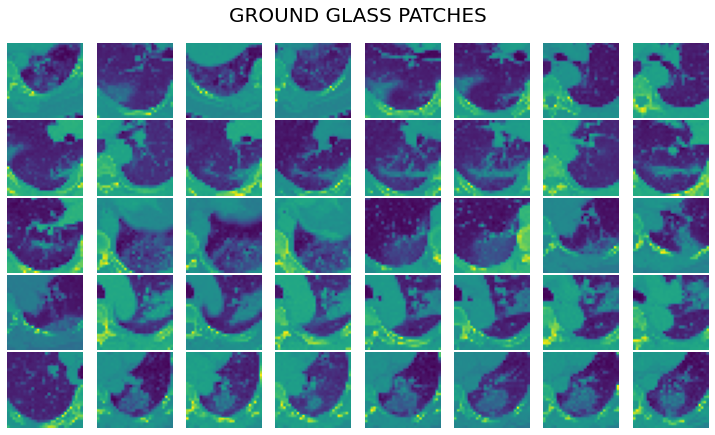

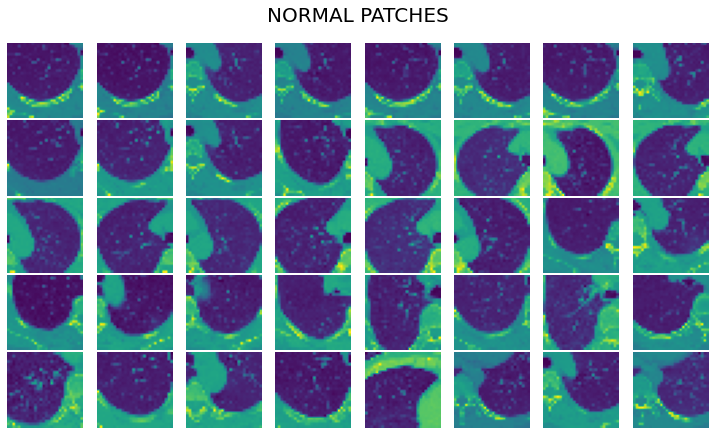

In [12]:
# Plotting the Positive COVID and Negative COVID datasets

Visualize_CT(gg_data, 'GROUND GLASS PATCHES')
Visualize_CT(normal_data, 'NORMAL PATCHES')

# Convert to array and Normalize to interval
gg_images = np.array(gg_data) / 255
normal_images = np.array(normal_data) / 255

In [13]:
# splitting train and test 

# covid data 
Xc_train, Xc_test, yc_train, yc_test = train_test_split(gg_data, gg_labels, test_size=0.2) # 80-20 split 
# normal data 
Xn_train, Xn_test, yn_train, yn_test = train_test_split(normal_data, normal_labels, test_size=0.2) # 80-20 split 

# concatenating the covid and normal data 
X_train = np.concatenate((Xc_train, Xn_train), axis=0)
X_test = np.concatenate((Xc_test, Xn_test), axis=0)
y_train = np.concatenate((yc_train, yn_train), axis=0)
y_test = np.concatenate((yc_test, yn_test), axis=0)

In [14]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime


%load_ext tensorboard

In [15]:
# shuffle the datasets 

X_train,y_train=shuffle(X_train,y_train, random_state=42)
X_test,y_test=shuffle(X_test,y_test, random_state=42)

In [16]:
print("Shape of Train Data :", X_train.shape)
print("Shape of Test Data:", X_test.shape)
print("Shape of Train Labels:", y_train.shape)
print("Shape of Test Labels :", y_test.shape)

Shape of Train Data : (150, 28, 28)
Shape of Test Data: (38, 28, 28)
Shape of Train Labels: (150,)
Shape of Test Labels : (38,)


In [17]:
# Parameters Based on Paper
epsilon = 1e-7
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
alpha = 0.0005
epochs = 50
no_of_secondary_capsules = 10

optimizer = tf.keras.optimizers.Adam()

In [18]:
params = {
    "no_of_conv_kernels": 256,
    "no_of_primary_capsules": 32,
    "no_of_secondary_capsules": 10,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":3,
}

In [19]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime


%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
X_train = X_train / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
X_train = tf.expand_dims(X_train, axis=-1)

X_test = X_test / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
X_test = tf.expand_dims(X_test, axis=-1)

In [21]:
testing_dataset_size = X_test.shape[0]
training_dataset_size = X_train.shape[0]

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size=10)

In [23]:
testing = tf.data.Dataset.from_tensor_slices((X_test, y_test))
testing = testing.batch(batch_size=10)

#### **Capsule Network Method Definition**

In [24]:
class CapsuleNetwork(tf.keras.Model):
    def __init__(self, no_of_conv_kernels, no_of_primary_capsules, primary_capsule_vector, no_of_secondary_capsules, secondary_capsule_vector, r):
        super(CapsuleNetwork, self).__init__()
        self.no_of_conv_kernels = no_of_conv_kernels
        self.no_of_primary_capsules = no_of_primary_capsules
        self.primary_capsule_vector = primary_capsule_vector
        self.no_of_secondary_capsules = no_of_secondary_capsules
        self.secondary_capsule_vector = secondary_capsule_vector
        self.r = r
        
        
        with tf.name_scope("Variables") as scope:
            self.convolution = tf.keras.layers.Conv2D(self.no_of_conv_kernels, [9,9], strides=[1,1], name='ConvolutionLayer', activation='relu')
            self.primary_capsule = tf.keras.layers.Conv2D(self.no_of_primary_capsules * self.primary_capsule_vector, [9,9], strides=[2,2], name="PrimaryCapsule")
            self.w = tf.Variable(tf.random_normal_initializer()(shape=[1, 1152, self.no_of_secondary_capsules, self.secondary_capsule_vector, self.primary_capsule_vector]), dtype=tf.float32, name="PoseEstimation", trainable=True)
            self.dense_1 = tf.keras.layers.Dense(units = 512, activation='relu')
            self.dense_2 = tf.keras.layers.Dense(units = 1024, activation='relu')
            self.dense_3 = tf.keras.layers.Dense(units = 784, activation='sigmoid', dtype='float32')
        
    def build(self, input_shape):
        pass
        
    def squash(self, s):
        with tf.name_scope("SquashFunction") as scope:
            s_norm = tf.norm(s, axis=-1, keepdims=True)
            return tf.square(s_norm)/(1 + tf.square(s_norm)) * s/(s_norm + epsilon)
    
    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)
        
        x = self.convolution(input_x) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((input_x.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
                
        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)
            
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        
        return v, reconstructed_image

    @tf.function
    def predict_capsule_output(self, inputs):
        x = self.convolution(inputs) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image

In [25]:
tf.summary.trace_on(graph=True, profiler=True)

Instructions for updating:
use `tf.profiler.experimental.start` instead.


In [26]:
model = CapsuleNetwork(**params)

#### **Loss Function**

In [27]:
def loss_function(v, reconstructed_image, y, y_image):
    prediction = safe_norm(v)
    prediction = tf.reshape(prediction, [-1, no_of_secondary_capsules])
    
    left_margin = tf.square(tf.maximum(0.0, m_plus - prediction))
    right_margin = tf.square(tf.maximum(0.0, prediction - m_minus))
    
    l = tf.add(y * left_margin, lambda_ * (1.0 - y) * right_margin)
    
    margin_loss = tf.reduce_mean(tf.reduce_sum(l, axis=-1))
    
    y_image_flat = tf.reshape(y_image, [-1, 784])
    reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))
    
    loss = tf.add(margin_loss, alpha * reconstruction_loss)
    
    return loss

In [28]:
def safe_norm(v, axis=-1):
    v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims=True)
    return tf.sqrt(v_ + epsilon)

In [29]:
def train(x,y):
    y_one_hot = tf.one_hot(y, depth=10)
    with tf.GradientTape() as tape:
        v, reconstructed_image = model([x, y_one_hot])
        loss = loss_function(v, reconstructed_image, y_one_hot, x)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [30]:
def predict(model, x):
    pred = safe_norm(model.predict_capsule_output(x))
    pred = tf.squeeze(pred, [1])
    return np.argmax(pred, axis=1)[:,0]

#### **Training Of Capsule Network Model**

In [31]:
losses = []
accuracy = []
for i in range(1, epochs+1, 1):

    loss = 0
    with tqdm(total=len(dataset)) as pbar:
        
        description = "Epoch " + str(i) + "/" + str(epochs)
        pbar.set_description_str(description)

        for X_batch, y_batch in dataset:

            loss += train(X_batch,y_batch)
            pbar.update(1)

        loss /= len(dataset)
        losses.append(loss.numpy())
        
        training_sum = 0

        print_statement = "Loss :" + str(loss.numpy()) + " Evaluating Accuracy ..."
        pbar.set_postfix_str(print_statement)

        for X_batch, y_batch in dataset:
            training_sum += sum(predict(model, X_batch)==y_batch.numpy())
        accuracy.append(training_sum/training_dataset_size)

        
        print_statement = "Loss :" + str(loss.numpy()) + " Accuracy :" + str(accuracy[-1])
        pbar.set_postfix_str(print_statement)

Epoch 50/50: 100%|██████████| 15/15 [00:01<00:00, 11.79it/s, Loss :0.0037796563 Accuracy :1.0]


#### **Test Accuracy Of Capsule Network Model**

In [32]:
test_sum = 0
for X_batch, y_batch in testing:
    test_sum += sum(predict(model, X_batch)==y_batch.numpy())
print(test_sum/testing_dataset_size)

0.9210526315789473


In [33]:
outputs = predict(model,X_test)

In [34]:
print(outputs.shape)

(38,)


In [35]:
# Model Predictions via test data 
# 1 indicates Infected Image
# 0 indicates Normal Image
for i in range(len(outputs)):
  if outputs[i]>0.5:
    outputs[i] = 1
    #print('Infected Patches')
  else:
    outputs[i] = 0
    #print('Normal Patches')
print(outputs)

[0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1
 0]


#### **Gradcam Heatmap**

In [36]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow   

In [37]:
X_test.shape

TensorShape([38, 28, 28, 1])

In [38]:
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

In [39]:
def gradCAM(orig, intensity=0.5, res=28):
  img = image.load_img(orig, target_size=(28, 28))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  #print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('Reconstruction')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((52, 52))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
  cv2_imshow(cv2.resize(img, (res, res)))

In [40]:
orig_1 = '/gdrive/My Drive/Dataset/Infected_Filter/volume-covid19-A-0031_37_256_128.png'